In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os

# SQLite Database Connection (No server needed!)
db_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'electronics_dw.db')
engine = create_engine(f'sqlite:///{db_path}')

# Test connection by listing tables
print('Connected! Available tables:')
print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", engine))

Connected! Available tables:
                      name
0             customer_dim
1     product_category_dim
2  product_subcategory_dim
3              product_dim
4                store_dim
5       exchange_rates_dim
6               sales_fact


Average Order Value: Per Store & Category


,Store_Name,Store_Country,Order_Year,Product_Category,Avg_Order_Value,Total_Orders
0,Store 1,Australia,2021,Cameras and camcorders,312.00,1
1,Store 1,Australia,2021,Games and Toys,16.99,1
2,Store 1,Australia,2021,"Music, Movies and Audio Books",602.99,2
3,Store 1,Australia,2021,TV and Video,1549.99,2
4,Store 1,Australia,2020,Audio,689.85,4
5,Store 1,Australia,2020,Cameras and camcorders,2418.60,5
6,Store 1,Australia,2020,Cell phones,705.54,13
7,Store 1,Australia,2020,Computers,1750.36,14
8,Store 1,Australia,2020,Games and Toys,72.66,13
9,Store 1,Australia,2020,Home Appliances,493.00,1


C:\Users\User\AppData\Local\Temp\ipykernel_13896\2917166853.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


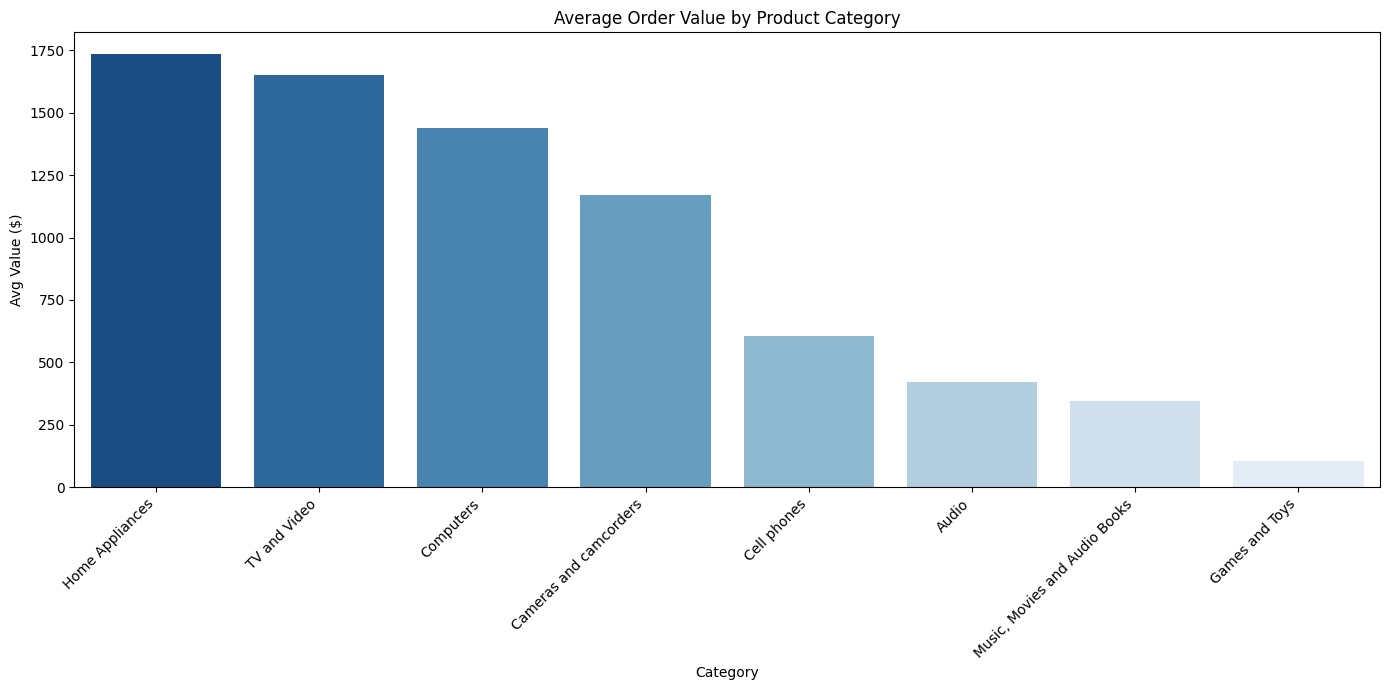

Saved Question A results to 'Question_A_Avg_Order_Value.csv'


In [15]:
# Question A: Average Order Value per Store, Product Category, Country, and Year

query_a = """
SELECT 
    s.store_name AS Store_Name,
    s.country AS Store_Country,
    strftime('%Y', f.order_date) AS Order_Year,
    c.category AS Product_Category,
    ROUND(AVG(f.total_revenue), 2) AS Avg_Order_Value,
    COUNT(*) AS Total_Orders
FROM sales_fact f
JOIN store_dim s ON f.store_key = s.store_key
JOIN product_dim p ON f.product_key = p.product_key
JOIN product_category_dim c ON p.category_key = c.category_key
GROUP BY s.store_name, s.country, strftime('%Y', f.order_date), c.category
ORDER BY Store_Country, Store_Name, Order_Year DESC;
"""

df_a = pd.read_sql(query_a, engine)

print("Average Order Value: Per Store & Category")
print("=" * 70)
# Show more rows to verify the granularity
display(df_a.head(15))

# Visualization: Avg Order Value by Category
plt.figure(figsize=(14, 7))
order = df_a.groupby('Product_Category')['Avg_Order_Value'].mean().sort_values(ascending=False).index
sns.barplot(
    data=df_a, 
    x='Product_Category', 
    y='Avg_Order_Value', 
    order=order,  
    estimator='mean', 
    errorbar=None, 
    palette='Blues_r' 
)
plt.title('Average Order Value by Product Category')
plt.ylabel('Avg Value ($)')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

# Save results to CSV
df_a.to_csv('Question_A_Avg_Order_Value.csv', index=False)
print("Saved Question A results to 'Question_A_Avg_Order_Value.csv'")

Average Delivery Time (Days) per Region - Quarterly


,Region,Year,Quarter,Avg_Delivery_Days
0,Australia,2020,1,3.7
1,Australia,2020,2,3.9
2,Australia,2020,3,5.5
3,Australia,2020,4,3.2
4,Australia,2021,1,3.8
5,Canada,2020,1,4.4
6,Canada,2020,2,3.9
7,Canada,2020,3,4.0
8,Canada,2020,4,4.0
9,Canada,2021,1,3.3


<Figure size 1600x600 with 0 Axes>

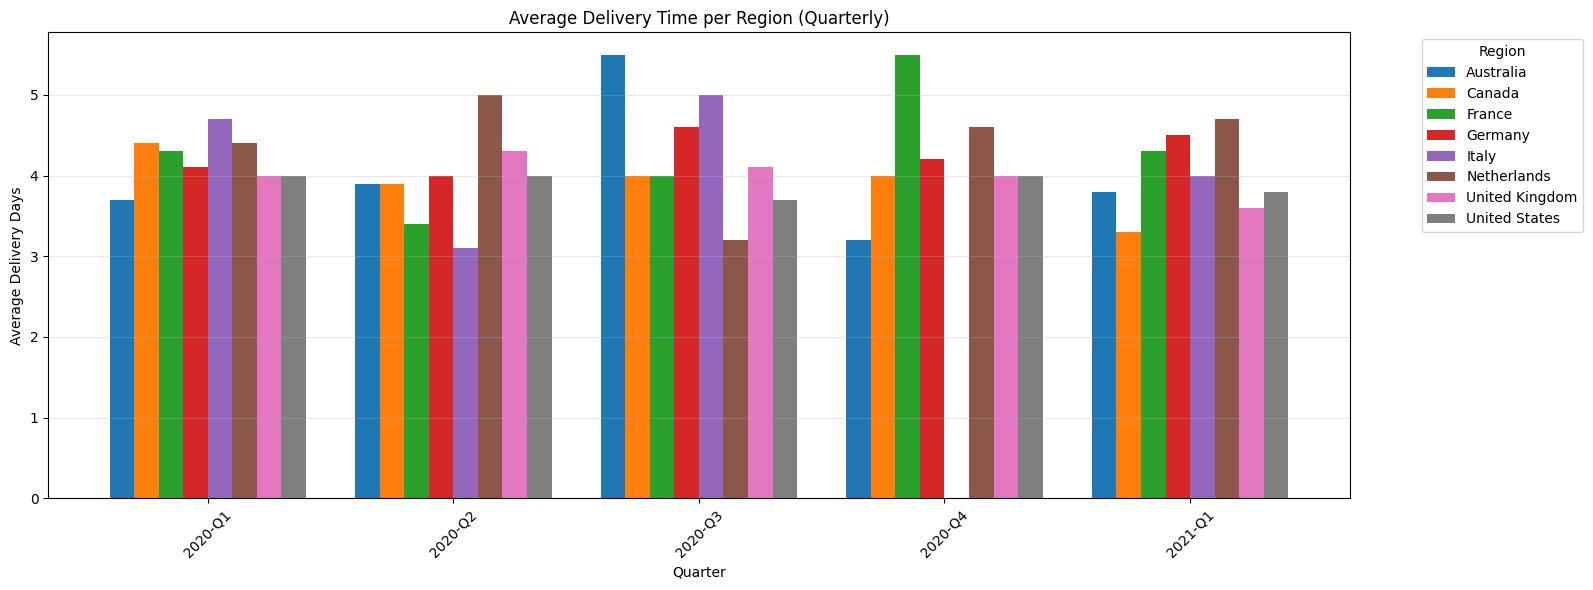

Saved Question B results to 'Question_B_Delivery_Time.csv'


In [16]:
# Question B: Average Delivery Time (Days) per Region - Quarterly

query_b = """
SELECT 
    c.country AS Region,
    strftime('%Y', f.order_date) AS Year,
    CAST((CAST(strftime('%m', f.order_date) AS INTEGER) + 2) / 3 AS INTEGER) AS Quarter,
    ROUND(AVG(julianday(f.delivery_date) - julianday(f.order_date)), 1) AS Avg_Delivery_Days
FROM sales_fact f
JOIN customer_dim c ON f.customer_key = c.customer_key
WHERE f.delivery_date IS NOT NULL
  AND CAST(strftime('%Y', f.order_date) AS INTEGER) >= 2020
GROUP BY c.country, strftime('%Y', f.order_date), Quarter
ORDER BY Region, Year, Quarter;
"""

df_b = pd.read_sql(query_b, engine)

print("Average Delivery Time (Days) per Region - Quarterly")
print("=" * 70)
display(df_b)

# Bar Graph Visualization
df_b['Year_Quarter'] = df_b['Year'] + '-Q' + df_b['Quarter'].astype(str)

plt.figure(figsize=(16, 6))
pivot_df = df_b.pivot(index='Year_Quarter', columns='Region', values='Avg_Delivery_Days')
pivot_df.plot(kind='bar', figsize=(16, 6), width=0.8)

plt.title('Average Delivery Time per Region (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Average Delivery Days')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# Save results to CSV
df_b.to_csv('Question_B_Delivery_Time.csv', index=False)
print("Saved Question B results to 'Question_B_Delivery_Time.csv'")

Brand Performance Summary


,Brand,Total_Revenue,Avg_Monthly_Revenue,Volatility
7,Southridge Video,"$2,578,596","$41,590",178.17%
1,Adventure Works,"$11,849,909","$191,128",292.73%
3,Fabrikam,"$6,807,894","$109,805",298.02%
9,The Phone Company,"$5,386,820","$86,884",299.56%
2,Contoso,"$10,792,325","$174,070",299.71%
8,Tailspin Toys,"$682,731","$11,012",333.76%
10,Wide World Importers,"$9,172,800","$147,948",585.96%
0,A. Datum,"$1,486,208","$24,364",646.50%
6,Proseware,"$3,212,628","$51,817",713.68%
5,Northwind Traders,"$1,126,070","$18,162",992.60%


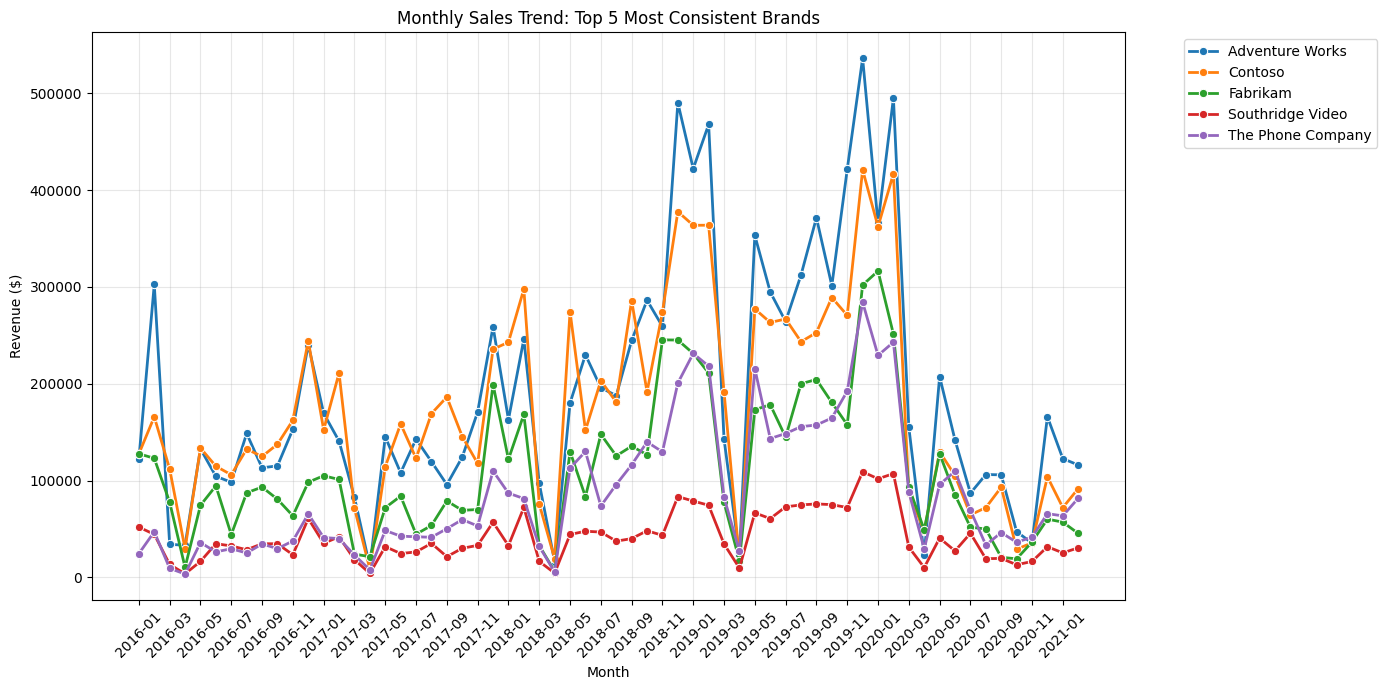

Saved Question C results to 'Question_C_Brand_Performance.csv'


In [17]:
# Question C: Revenue & Growth Consistency per Brand (Summary of ALL Brands)

query_c = """
SELECT 
    p.brand AS Brand,
    strftime('%Y-%m', f.order_date) AS Month,
    SUM(f.total_revenue) AS Monthly_Revenue
FROM sales_fact f
JOIN product_dim p ON f.product_key = p.product_key
GROUP BY p.brand, strftime('%Y-%m', f.order_date)
ORDER BY Brand, Month;
"""
df_c = pd.read_sql(query_c, engine)

# 2. Calculate Summary Metrics per Brand
brand_summary = df_c.groupby('Brand').agg(
    Total_Revenue=('Monthly_Revenue', 'sum'),
    Avg_Monthly_Revenue=('Monthly_Revenue', 'mean')
).reset_index()

# 3. Calculate Consistency (Standard Deviation of Growth)
stability_scores = []
for brand in df_c['Brand'].unique():
    brand_df = df_c[df_c['Brand'] == brand]
    if len(brand_df) > 1:
        # Calculate volatility of month-over-month changes
        volatility = brand_df['Monthly_Revenue'].pct_change().std()
        stability_scores.append({'Brand': brand, 'Volatility': volatility})
    else:
        # If brand only has 1 month of sales, volatility is undefined (use 0 or NaN)
        stability_scores.append({'Brand': brand, 'Volatility': float('nan')})

# Merge and Sort
growth_df = pd.DataFrame(stability_scores)
final_df = brand_summary.merge(growth_df, on='Brand')
final_df = final_df.sort_values('Volatility', ascending=True) 

print("Brand Performance Summary")
print("=" * 80)

# Format for nice display
display_df = final_df.copy()
display_df['Total_Revenue'] = display_df['Total_Revenue'].map('${:,.0f}'.format)
display_df['Avg_Monthly_Revenue'] = display_df['Avg_Monthly_Revenue'].map('${:,.0f}'.format)
display_df['Volatility'] = display_df['Volatility'].map('{:.2%}'.format)

pd.set_option('display.max_rows', None) 
display(display_df)
pd.reset_option('display.max_rows')      

import matplotlib.dates as mdates
# Visualization: Top 5 Most Consistent Brands
top_5_consistent = final_df.dropna().head(5)['Brand'].tolist()
df_top = df_c[df_c['Brand'].isin(top_5_consistent)].copy()
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_top, x='Month', y='Monthly_Revenue', hue='Brand', marker='o', linewidth=2)
plt.title('Monthly Sales Trend: Top 5 Most Consistent Brands')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
unique_months = sorted(df_top['Month'].unique())
plt.xticks(
    ticks=range(0, len(unique_months), 2),  
    labels=unique_months[::2],              
    rotation=45
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout() 
plt.show()

# Save results to CSV
display_df.to_csv('Question_C_Brand_Performance.csv', index=False)
print("Saved Question C results to 'Question_C_Brand_Performance.csv'")

Top Categories by Sales Volume: Peak vs. Off-Peak


,Category,Subcategory,Season,Sales_Volume,Purchase_Frequency
0,"Music, Movies and Audio Books",Movie DVD,Off-Peak (Q1-Q3),20128,5499
1,Computers,Desktops,Off-Peak (Q1-Q3),14230,4003
2,Audio,Bluetooth Headphones,Off-Peak (Q1-Q3),9686,2827
3,"Music, Movies and Audio Books",Movie DVD,Peak Season (Q4),8674,2285
4,Games and Toys,Download Games,Off-Peak (Q1-Q3),8029,2352
5,Games and Toys,Boxed Games,Off-Peak (Q1-Q3),7763,2238
6,Cell phones,Touch Screen Phones,Off-Peak (Q1-Q3),7464,2210
7,Cell phones,Smart phones & PDAs,Off-Peak (Q1-Q3),7033,2170
8,Computers,Desktops,Peak Season (Q4),6396,1748
9,Audio,Recording Pen,Off-Peak (Q1-Q3),4525,1392


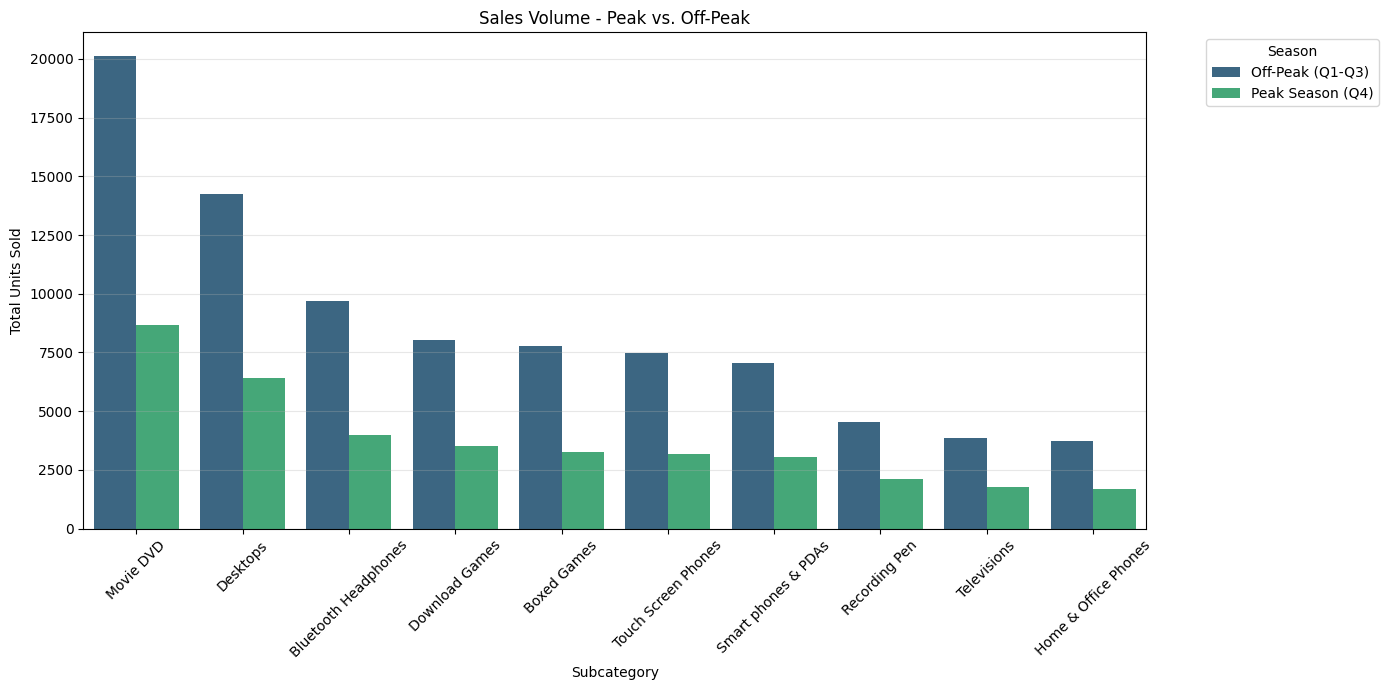

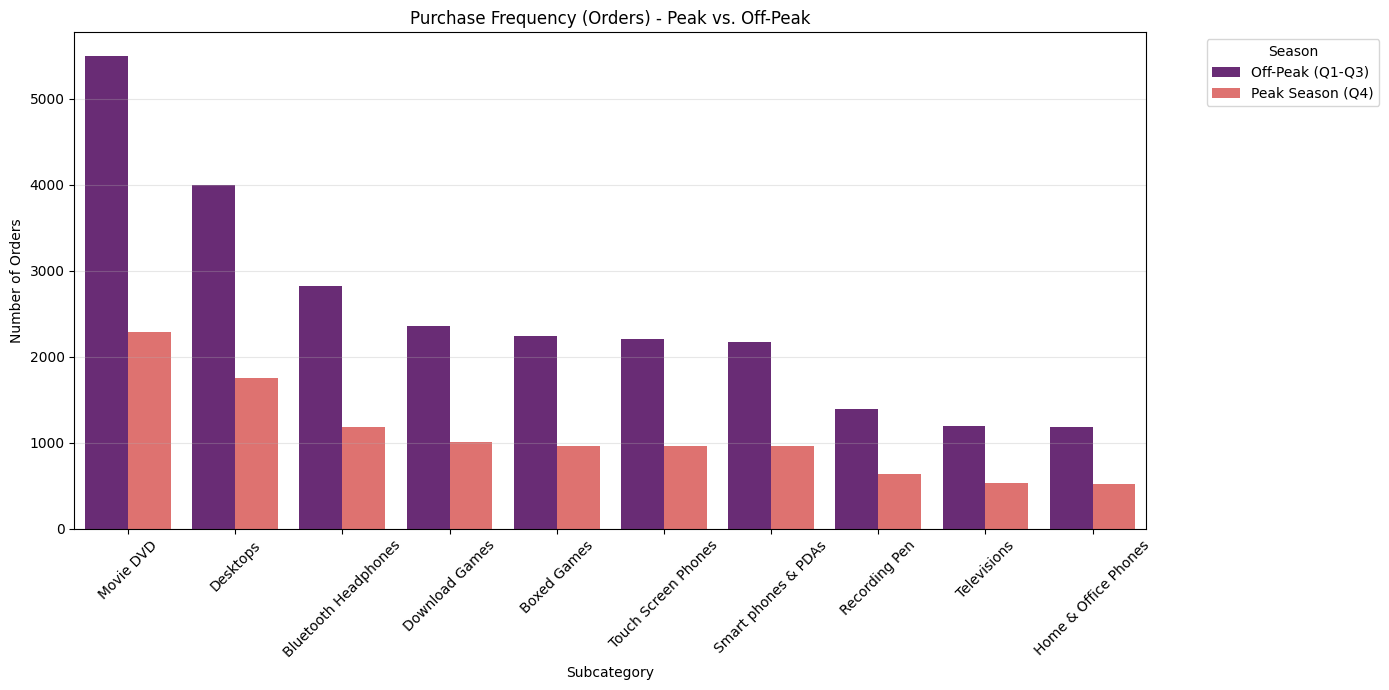

Saved Question D results to 'Question_D_Seasonal_Performance.csv'


In [18]:
# Question D: Category Performance - Peak (Q4) vs. Off-Peak (Q1-Q3) Seasons
# Peak Season = October, November, December (Months 10-12)
# Off-Peak = January - September (Months 01-09)

query_d = """
SELECT 
    c.category AS Category,
    sc.subcategory AS Subcategory,
    CASE 
        WHEN CAST(strftime('%m', f.order_date) AS INTEGER) IN (10, 11, 12) THEN 'Peak Season (Q4)'
        ELSE 'Off-Peak (Q1-Q3)'
    END AS Season,
    SUM(f.quantity) AS Sales_Volume,
    COUNT(DISTINCT f.order_number) AS Purchase_Frequency
FROM sales_fact f
JOIN product_dim p ON f.product_key = p.product_key
JOIN product_category_dim c ON p.category_key = c.category_key
JOIN product_subcategory_dim sc ON p.subcategory_key = sc.subcategory_key
GROUP BY 1, 2, 3
ORDER BY Sales_Volume DESC;
"""

df_d = pd.read_sql(query_d, engine)

print("Top Categories by Sales Volume: Peak vs. Off-Peak")
print("=" * 80)
display(df_d.head(10))

# Visualization: Compare Sales Volume for Top Subcategories per Season
top_subcats = df_d.groupby('Subcategory')['Sales_Volume'].sum().nlargest(10).index
df_viz = df_d[df_d['Subcategory'].isin(top_subcats)]

plt.figure(figsize=(14, 7))
sns.barplot(data=df_viz, x='Subcategory', y='Sales_Volume', hue='Season', palette='viridis')
plt.title('Sales Volume - Peak vs. Off-Peak')
plt.xlabel('Subcategory')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Visualize Purchase Frequency
plt.figure(figsize=(14, 7))
sns.barplot(data=df_viz, x='Subcategory', y='Purchase_Frequency', hue='Season', palette='magma')
plt.title('Purchase Frequency (Orders) - Peak vs. Off-Peak')
plt.xlabel('Subcategory')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Save results to CSV
df_d.to_csv('Question_D_Seasonal_Performance.csv', index=False)
print("Saved Question D results to 'Question_D_Seasonal_Performance.csv'")